In [ ]:
import pandas as pd
import numpy as np
import pymc

from dstk.pymc_utils import make_bernoulli, make_categorical, cartesian_child


def get_rsw_data(size):
    """generates a data from the famous 'rain - sprinkler - wet grass' bayesian network
    returns as a dataframe.
    """
    
    coefficients = {
        'CF: p(rain)': 0.2,
        'CF: p(grass_wet | sprinkler=0 rain=0)': 0.,
        'CF: p(grass_wet | sprinkler=0 rain=1)': 0.8,
        'CF: p(grass_wet | sprinkler=1 rain=0)': 0.9,
        'CF: p(grass_wet | sprinkler=1 rain=1)': 0.99,
        'CF: p(sprinkler | rain=0)': 0.4,
        'CF: p(sprinkler | rain=1)': 0.01
    }
    
    # define the bayesian net
    rain = make_bernoulli('rain', N=1, fixed=coefficients)
    sprinkler = cartesian_child('sprinkler', parents=[rain], levels=2, N=1, fixed=coefficients)
    grass_wet = cartesian_child('grass_wet', parents=[sprinkler, rain], levels=2, N=1, fixed=coefficients)
    
    # sample from the prior
    model = pymc.Model([rain, sprinkler, grass_wet])
    sampler = pymc.MCMC(model)
    sampler.sample(iter=size, burn=0)

    data = pd.DataFrame({
        str(node): sampler.trace(str(node))[:].ravel() + 0
        for node in sampler.stochastics
    })
    return data

see how it works

In [ ]:
get_rsw_data(5)

In [ ]:
from dstk.imputation import BayesNetImputer
from dstk.pymc_utils import cartesian_child, make_bernoulli


class RainSprinklerGrassImputer(BayesNetImputer):
    """the famous Rain-Sprinkler-Wet bayesian network"""

    def construct_net(self, df):
        # This is the same network as was used to generate the data, but there
        # are some differences in how it is set up:
        # - we don't fix the values of coefficients - the whole point is for the model to learn them!
        # - we provide 'value' parameter - because these variables are observed
        # - we don't need the 'N' parameter - because it is assumed that N = len(value)
        rain = make_bernoulli('rain', value=df.rain)
        sprinkler = make_bernoulli('sprinkler', value=df.sprinkler)
        grass_wet = cartesian_child('grass_wet', parents=[rain, sprinkler], levels=2, value=df.grass_wet)

        model = pymc.Model([rain, sprinkler, grass_wet])
        return model

instantiate a few different versions of the model. All of them predict values by maximising joint posterior probability of all the variables - both observed ('rain', 'sprinkler', 'grass_wet') and unobserved  ('p(rain)', 'p(grass_wet | sprinkler=0 rain=0)', etc.). But there are many ways to do that. One way is to use MCMC (`method='MCMC'`)to generate samples from the posterior and take the most frequent value. Another - to directly maximise the likelihoos function (`method='MAP'`).

In [ ]:
MCMC_500 = RainSprinklerGrassImputer(method='MCMC', iter=700, burn=500)
# more iterations to burn in - more likely to converge on the best solution, but takes more time to fit
MCMC_2000 = RainSprinklerGrassImputer(method='MCMC', iter=2200, burn=2000)
MCMC_10000 = RainSprinklerGrassImputer(method='MCMC', iter=10200, burn=10000)
# directly optimise with scipy
MAP_fmin = RainSprinklerGrassImputer(method='MAP', opt_method='fmin')
MAP_fmin_powell = RainSprinklerGrassImputer(method='MAP', opt_method='fmin_powell')

The interface of all imputers in dstk is the same: they have a 'fit_transform' method that takes a dataframe where some values are replaced with -1 (or np.NaN for continuous columns) and return a dataframe where those entries are filled in. 

In the following trivial example 
```
(grass_wet = 1) if and only if ((rain = 1) OR (sprinkler = 1))
```
So when one of the records has `grass_wet = 0` and `rain` and `sprinkler` are missing, the network correctly predicts that both `rain` and `sprinkler` must be ` = 0`:

In [ ]:
M = -1

df_with_missing_values = pd.DataFrame({
    'rain':      [0,0,1,1,M],
    'sprinkler': [0,1,0,1,M],
    'grass_wet': [0,1,1,1,0]
})

MCMC_10000.fit_transform(df_with_missing_values)

Or at least, it does when it has 10000 iterations to burn in. The same network with only 2000 iterations, doesn't always get this one right.

Now, let's add other types of missing values imputers so we have something to benchmark against.

MLImputer fits a specified regression or classification algorithm to each column to predict the value of that column given the values of all the other columns of the dataframe. The base regressor or classififer can be any model that conforms to the sklearn convention of `.fit(X, y)`, `.predict(X)`.

In [ ]:
# prevent the models from printing too much
from dstk.utils import logger
logger.setLevel('WARN')

from dstk.imputation import DefaultImputer, BayesNetImputer, MLImputer
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier


# let's use XBBClassifier as the base classifier because it's pretty great out-of-the-box
xgb_imputer = MLImputer(base_classifier=XGBClassifier)
# let's add a dummy model that will simply predict the most frequent value for every column
dummy_imputer = MLImputer(base_classifier=lambda: DummyClassifier(strategy="most_frequent"))

Now we're ready to do some benchmarking!

In [58]:
from dstk.imputation.benchmarking import benchmark
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def compare_imputers(date_getter, missing_fraction, data_sizes, models, iterations):
    results = []
    for i in range(iterations):
        for n in data_sizes:
            np.random.seed(i)
            data = data_getter(n)
            for model_name, model in models:
                all_scores = benchmark(model, data, missing_fraction, seed=i)
                time = all_scores['ELAPSED_TIME']
                score = np.mean([x for key, x in all_scores.items() if key != 'ELAPSED_TIME'])
                results.append((model_name, n, score, all_scores['ELAPSED_TIME']))

    results = pd.DataFrame(results)
    results.columns = ['model', 'n', 'accuracy', 'training time']
    return results
    
def plot_shit(results, width=12, height=6):
    plt.figure(figsize=(width, height))
    sns.pointplot(x='n', y='accuracy', hue='model', data=results, dodge=True)
    plt.show()
    fig = plt.figure(figsize=(width, height))
    sns.pointplot(x='n', y='training time', hue='model', data=results, dodge=True)
    fig.get_axes()[0].set_yscale('log')
    

In [ ]:
%%capture
missing_fraction = 0.2
data_getter = get_rsw_data
data_sizes = [5, 10, 50, 250]
iterations = 5
models = [
    ('xgboost' , xgb_imputer),
    ('most frequent', dummy_imputer),
    ('MCMC_500', MCMC_500),
    ('MCMC_2000', MCMC_2000),
    ('MCMC_10000', MCMC_10000),
    ('MAP_fmin', MAP_fmin),
    ('MAP_fmin_powell', MAP_fmin_powell)
]

results = compare_imputers(get_rsw_data, missing_fraction, data_sizes, models, iterations)

In [ ]:
plot_shit(results)

`MAP_fmin` is out. It's not only the worst performing (worse than the dummy!) but also terribly slow. 

In [ ]:
%%capture
from time import time
start = time()
missing_fraction = 0.2
data_getter = get_rsw_data
data_sizes = [10, 50, 250, 1250]
iterations = 5
models = [
    ('xgboost' , xgb_imputer),
    ('most frequent', dummy_imputer),
    ('MCMC_500', MCMC_500),
    ('MCMC_2000', MCMC_2000),
    ('MCMC_10000', MCMC_10000),
    ('MAP_fmin_powell', MAP_fmin_powell)
]

results2 = compare_imputers(get_rsw_data, missing_fraction, data_sizes, models, iterations)
end = time()


In [ ]:
print end - start

In [ ]:
plot_shit(results2)

In [48]:

def get_cancer_data(size):
    anxiety = make_bernoulli('anxiety', N=1)
    peer_pressure = make_bernoulli('peer_pressure', N=1)
    smoking = cartesian_child('smoking', parents=[anxiety, peer_pressure], N=1)
    yellow_fingers = cartesian_child('yellow_fingers', parents=[smoking], N=1)
    genetics = make_bernoulli('genetics', N=1)
    lung_cancer = cartesian_child('lung_cancer', parents=[smoking, genetics], N=1)
    allergy = make_bernoulli('allergy', N=1)
    coughing = cartesian_child('coughing', parents=[allergy, lung_cancer], N=1)
    fatigue = cartesian_child('fatigue', parents=[lung_cancer, coughing], N=1)
    attention_disorder = cartesian_child('attention_disorder', parents=[genetics], N=1)
    car_accident = cartesian_child('car_accident', parents=[fatigue, attention_disorder], N=1)
    model = pymc.Model([
        anxiety, 
        peer_pressure, 
        smoking, 
        yellow_fingers, 
        genetics, 
        lung_cancer, 
        allergy, 
        coughing, 
        fatigue,
        attention_disorder,
        car_accident
    ])
    coefficients = sample_coeffs(model)

    
    anxiety = make_bernoulli('anxiety', N=1, fixed=coefficients)
    peer_pressure = make_bernoulli('peer_pressure', N=1, fixed=coefficients)
    smoking = cartesian_child('smoking', parents=[anxiety, peer_pressure], N=1, fixed=coefficients)
    yellow_fingers = cartesian_child('yellow_fingers', parents=[smoking], N=1, fixed=coefficients)
    genetics = make_bernoulli('genetics', N=1, fixed=coefficients)
    lung_cancer = cartesian_child('lung_cancer', parents=[smoking, genetics], N=1, fixed=coefficients)
    allergy = make_bernoulli('allergy', N=1, fixed=coefficients)
    coughing = cartesian_child('coughing', parents=[allergy, lung_cancer], N=1, fixed=coefficients)
    fatigue = cartesian_child('fatigue', parents=[lung_cancer, coughing], N=1, fixed=coefficients)
    attention_disorder = cartesian_child('attention_disorder', parents=[genetics], N=1, fixed=coefficients)
    car_accident = cartesian_child('car_accident', parents=[fatigue, attention_disorder], N=1, fixed=coefficients)
    
    
    # sample from the prior
    model = pymc.Model([
        anxiety, 
        peer_pressure, 
        smoking, 
        yellow_fingers, 
        genetics, 
        lung_cancer, 
        allergy, 
        coughing, 
        fatigue,
        attention_disorder,
        car_accident
    ])
    sampler = pymc.MCMC(model)
    sampler.sample(iter=size, burn=0)

    data = pd.DataFrame({
        str(node): sampler.trace(str(node))[:].ravel() + 0
        for node in sampler.stochastics
    })
    return data

In [40]:
class CancerAndStuffImputer(BayesNetImputer):
    """network structure borrowed from
    http://www.causality.inf.ethz.ch/data/LUCAS.html"""

    def construct_net(self, df):
        anxiety = make_bernoulli('anxiety', N=1)
        peer_pressure = make_bernoulli('peer_pressure', N=1)
        smoking = cartesian_child('smoking', parents=[anxiety, peer_pressure], N=1)
        yellow_fingers = cartesian_child('yellow_fingers', parents=[smoking], N=1)
        genetics = make_bernoulli('genetics', value=df.genetics)
        lung_cancer = cartesian_child('lung_cancer', parents=[smoking, genetics], N=1)
        allergy = make_bernoulli('allergy', value=df.allergy)
        coughing = cartesian_child('coughing', parents=[allergy, lung_cancer], N=1)
        fatigue = cartesian_child('fatigue', parents=[lung_cancer, coughing], N=1)
        attention_disorder = cartesian_child('attention_disorder', parents=[genetics], N=1)
        car_accident = cartesian_child('car_accident', parents=[fatigue, attention_disorder], N=1)
        model = pymc.Model([
            anxiety, 
            peer_pressure, 
            smoking, 
            yellow_fingers, 
            genetics, 
            lung_cancer, 
            allergy, 
            coughing, 
            fatigue,
            attention_disorder,
            car_accident
        ])
        coefficients = sample_coeffs(model)
        
        anxiety = make_bernoulli('anxiety', value=df.anxiety, fixed=coefficients)
        peer_pressure = make_bernoulli('peer_pressure', value=df.peer_pressure, fixed=coefficients)
        smoking = cartesian_child('smoking', parents=[anxiety, peer_pressure], value=df.smoking, fixed=coefficients)
        yellow_fingers = cartesian_child('yellow_fingers', parents=[smoking], value=df.yellow_fingers, fixed=coefficients)
        genetics = make_bernoulli('genetics', value=df.genetics, fixed=coefficients)
        lung_cancer = cartesian_child('lung_cancer', parents=[smoking, genetics], value=df.lung_cancer, fixed=coefficients)
        allergy = make_bernoulli('allergy', value=df.allergy, fixed=coefficients)
        coughing = cartesian_child('coughing', parents=[allergy, lung_cancer], value=df.coughing, fixed=coefficients)
        fatigue = cartesian_child('fatigue', parents=[lung_cancer, coughing], value=df.fatigue, fixed=coefficients)
        attention_disorder = cartesian_child('attention_disorder', parents=[genetics], value=df.attention_disorder, fixed=coefficients)
        car_accident = cartesian_child('car_accident', parents=[fatigue, attention_disorder], value=df.car_accident, fixed=coefficients)
        
        # sample from the prior
        model = pymc.Model([
            anxiety, 
            peer_pressure, 
            smoking, 
            yellow_fingers, 
            genetics, 
            lung_cancer, 
            allergy, 
            coughing, 
            fatigue,
            attention_disorder,
            car_accident
        ])
        return model

In [ ]:
from joblib import Memory
cachedir = "cache"

In [ ]:
from benchmarking import get_cancer_data_random_coeffs, MLImputer, XGBClassifier

In [ ]:
data = get_cancer_data_random_coeffs(4)

In [ ]:
imputer = MLImputer(base_classifier=XGBClassifier)

In [ ]:
data

In [ ]:
from benchmarking import get_rsw_data_random_coeffs, get_rsw_data

In [ ]:
from benchmarking import *

In [ ]:
rain = make_bernoulli('rain', value=df.rain)
sprinkler = make_bernoulli('sprinkler', value=df.sprinkler)
grass_wet = cartesian_child('grass_wet', parents=[rain, sprinkler], levels=2, value=df.grass_wet)

model = pymc.Model([rain, sprinkler, grass_wet])


In [ ]:
coefficients = {}
size  = 4
# define the bayesian net
rain = make_bernoulli('rain', N=1, fixed=coefficients)
sprinkler = cartesian_child('sprinkler', parents=[rain], levels=2, N=1, fixed=coefficients)
grass_wet = cartesian_child('grass_wet', parents=[sprinkler, rain], levels=2, N=1, fixed=coefficients)

# sample from the prior
model = pymc.Model([rain, sprinkler, grass_wet])
sampler = pymc.MCMC(model)
sampler.sample(iter=size, burn=0)

In [ ]:
sampler.nodes

In [1]:
from benchmarking import benchmark1, benchmark2, benchmark3

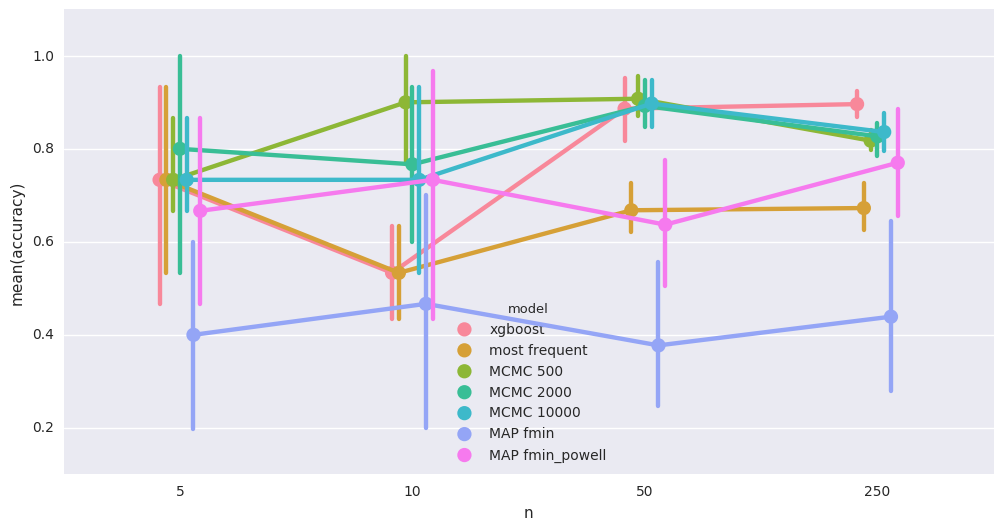

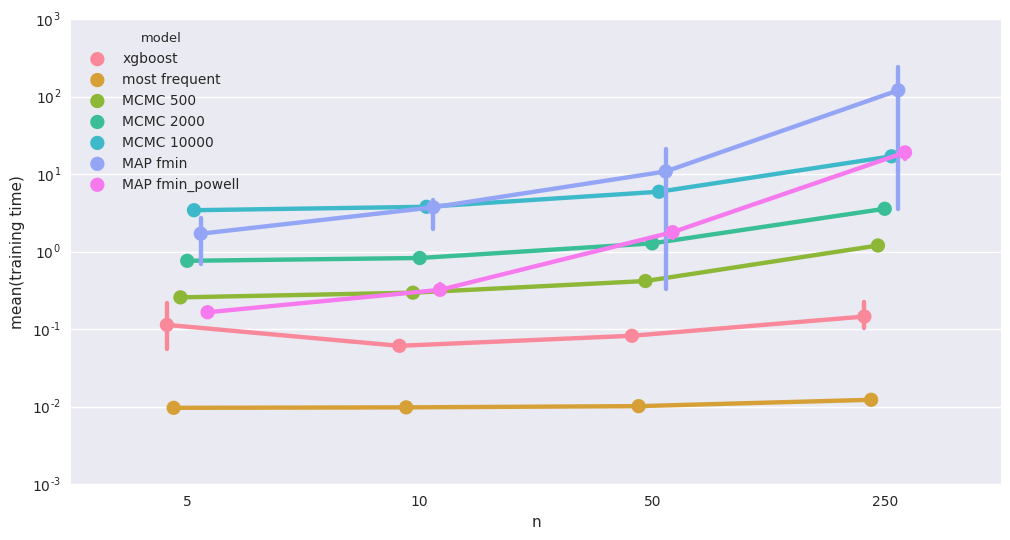

In [59]:
plot_shit(pd.read_csv('benchmark1.csv'))

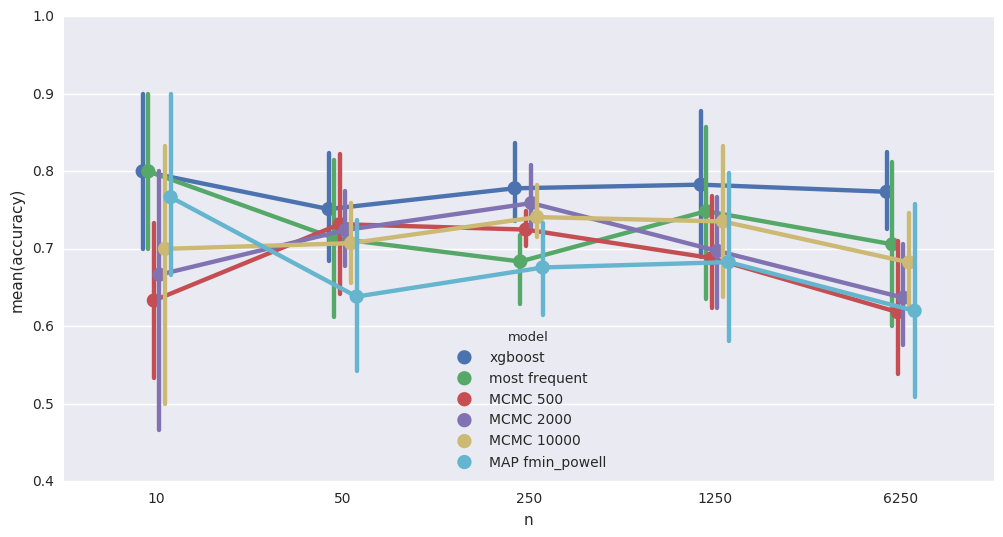

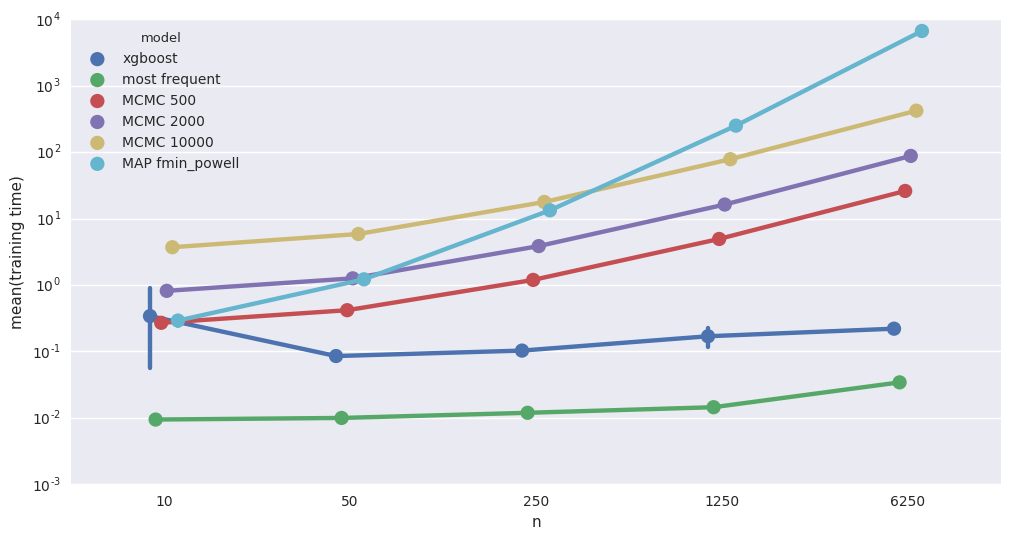

In [60]:
plot_shit(pd.read_csv('benchmark2.csv'))

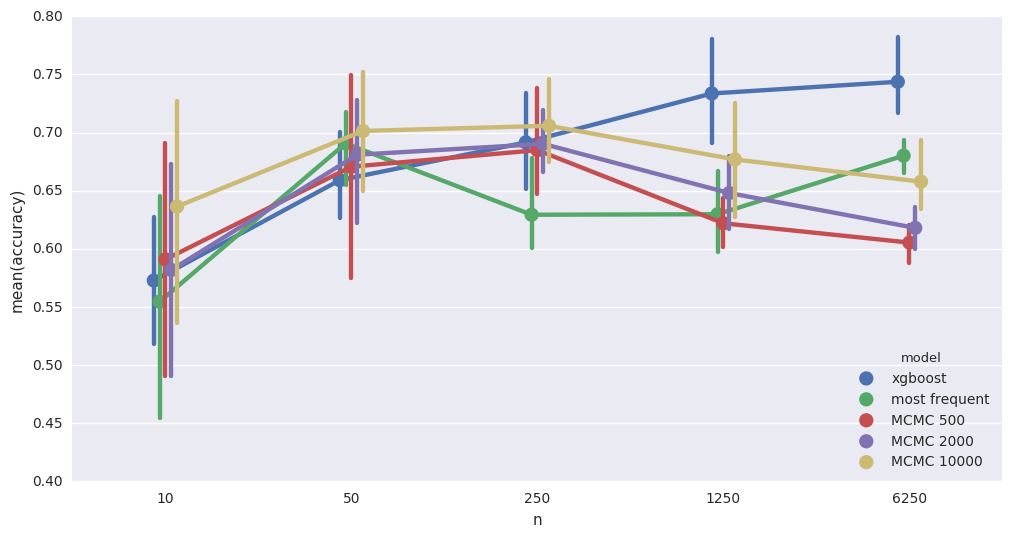

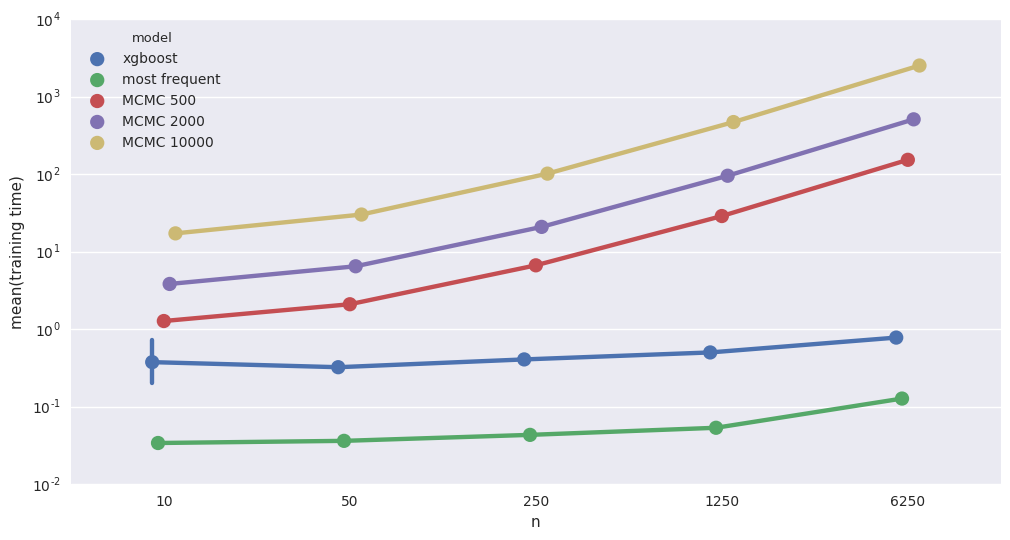

In [61]:
plot_shit(pd.read_csv('benchmark3.csv'))

In [15]:
from benchmarking import *

In [18]:
get_rsw_data_random_coeffs(100)

 [-----------------100%-----------------] 100 of 100 complete in 0.1 sec

,grass_wet,rain,sprinkler
0,0,0,1
1,1,1,1
2,0,1,1
3,1,1,0
4,1,0,0
5,1,1,1
6,0,0,0
7,0,1,1
8,1,0,1
9,1,1,1


In [50]:
%%capture
from dstk.pymc_utils import sample_coeffs
def get_rsw_data_random_coeffs(size):
    """generates a data from the famous 'rain - sprinkler - wet grass' bayesian network
    returns as a dataframe.
    """
    rain = make_bernoulli('rain', N=1)
    sprinkler = cartesian_child('sprinkler', parents=[rain], levels=2, N=1)
    grass_wet = cartesian_child('grass_wet', parents=[sprinkler, rain], levels=2, N=1)
    
    # sample from the prior
    model = pymc.Model([rain, sprinkler, grass_wet])
    coefficients = sample_coeffs(model)
    
    
    # define the bayesian net
    rain = make_bernoulli('rain', N=1, fixed=coefficients)
    sprinkler = cartesian_child('sprinkler', parents=[rain], levels=2, N=1, fixed=coefficients)
    grass_wet = cartesian_child('grass_wet', parents=[sprinkler, rain], levels=2, N=1, fixed=coefficients)
    
    # sample from the prior
    model = pymc.Model([rain, sprinkler, grass_wet])
    sampler = pymc.MCMC(model)
    sampler.sample(iter=size+1000, burn=1000)

    data = pd.DataFrame({
        str(node): sampler.trace(str(node))[:].ravel() + 0
        for node in sampler.stochastics if not str(node).startswith('CF: ')
    })
    return data




from time import time
start = time()
missing_fraction = 0.2
data_getter = get_cancer_data
data_sizes = [2250]
iterations = 1
models = [
    ('xgboost' , MLImputer(base_classifier=XGBClassifier))
]

res = compare_imputers(data_getter, missing_fraction, data_sizes, models, iterations)
end = time()
res


,model,n,accuracy,training time
0,xgboost,2250,0.719233,0.647902


In [49]:
get_cancer_data(4)

 [-----------------100%-----------------] 4 of 4 complete in 0.0 sec

,allergy,anxiety,attention_disorder,car_accident,coughing,fatigue,genetics,lung_cancer,peer_pressure,smoking,yellow_fingers
0,0,0,0,0,0,1,0,0,0,1,0
1,1,0,0,0,0,1,0,0,1,1,0
2,0,1,1,0,0,1,0,0,1,0,1
3,0,0,1,1,1,0,0,0,0,1,0


In [70]:
def get_car_data_random_coeffs(size):
    mileage=make_bernoulli('mileage', N=1)
    age = make_bernoulli('age', N=1)
    socio_econ = cartesian_child('socio_econ', parents=[age], N=1)
    risk_aversion = cartesian_child('risk_aversion', parents=[age, socio_econ], N=1)
    senior_train = cartesian_child('senior_train', parents=[age, risk_aversion], N=1)
    good_student = cartesian_child('good_student', parents=[age, socio_econ], N=1)
    extra_car = cartesian_child('extra_car', parents=[socio_econ], N=1)
    driving_skill = cartesian_child('driving_skill', parents=[age, senior_train], N=1)
    driving_hist = cartesian_child('driving_hist', parents=[driving_skill, risk_aversion], N=1)
    driving_quality = cartesian_child('driving_quality', parents=[driving_skill, risk_aversion], N=1)
    make_model = cartesian_child('make_model', parents=[risk_aversion, socio_econ], N=1)
    vehicle_year = cartesian_child('vehicle_year', parents=[socio_econ], N=1)
    antilock = cartesian_child('antilock', parents=[make_model, vehicle_year], N=1)
    ruggedness = cartesian_child('ruggedness', parents=[make_model, antilock], N=1)
    accident = cartesian_child('accident', parents=[driving_quality, antilock, mileage], N=1)
    airbag = cartesian_child('airbag', parents=[make_model, vehicle_year], N=1)
    car_value = cartesian_child('car_value', parents=[make_model, mileage, vehicle_year], N=1)
    home_base = cartesian_child('home_base', parents=[risk_aversion, socio_econ], N=1)
    anti_theft = cartesian_child('anti_theft', parents=[risk_aversion, socio_econ], N=1)
    theft = cartesian_child('theft', parents=[car_value, home_base, anti_theft], N=1)
    own_damage = cartesian_child('own_damage', parents=[ruggedness, accident], N=1)
    own_car_cost = cartesian_child('own_car_cost', parents=[own_damage, car_value, theft], N=1)
    cushioning = cartesian_child('cushioning', parents=[ruggedness, accident], N=1)
    medical_cost = cartesian_child('medical_cost', parents=[age, cushioning, accident], N=1)
    liability_cost = cartesian_child('liability_cost', parents=[accident], N=1)
    other_car_cost = cartesian_child('other_car_cost', parents=[ruggedness, accident], N=1)
    property_cost = cartesian_child('property_cost', parents=[other_car_cost, own_car_cost], N=1)
    
    
    model = pymc.Model([
        mileage,
        age,
        socio_econ,
        good_student,
        extra_car,
        driving_skill,
        risk_aversion,
        senior_train,
        driving_hist,
        driving_quality,
        make_model,
        vehicle_year,
        antilock,
        ruggedness,
        accident,
        airbag,
        car_value,
        home_base,
        anti_theft,
        theft,
        own_damage,
        own_car_cost,
        cushioning,
        medical_cost,
        liability_cost,
        other_car_cost,
        property_cost
    ])
    
    coefficients = sample_coeffs(model)
    
    mileage=make_bernoulli('mileage', N=1, fixed=coefficients)
    age = make_bernoulli('age', N=1, fixed=coefficients)
    socio_econ = cartesian_child('socio_econ', parents=[age], N=1, fixed=coefficients)
    risk_aversion = cartesian_child('risk_aversion', parents=[age, socio_econ], N=1, fixed=coefficients)
    senior_train = cartesian_child('senior_train', parents=[age, risk_aversion], N=1, fixed=coefficients)
    good_student = cartesian_child('good_student', parents=[age, socio_econ], N=1, fixed=coefficients)
    extra_car = cartesian_child('extra_car', parents=[socio_econ], N=1, fixed=coefficients)
    driving_skill = cartesian_child('driving_skill', parents=[age, senior_train], N=1)
    driving_hist = cartesian_child('driving_hist', parents=[driving_skill, risk_aversion], N=1, fixed=coefficients)
    driving_quality = cartesian_child('driving_quality', parents=[driving_skill, risk_aversion], N=1, fixed=coefficients)
    make_model = cartesian_child('make_model', parents=[risk_aversion, socio_econ], N=1, fixed=coefficients)
    vehicle_year = cartesian_child('vehicle_year', parents=[socio_econ], N=1, fixed=coefficients)
    antilock = cartesian_child('antilock', parents=[make_model, vehicle_year], N=1, fixed=coefficients)
    ruggedness = cartesian_child('ruggedness', parents=[make_model, antilock], N=1, fixed=coefficients)
    accident = cartesian_child('accident', parents=[driving_quality, antilock, mileage], N=1, fixed=coefficients)
    airbag = cartesian_child('airbag', parents=[make_model, vehicle_year], N=1, fixed=coefficients)
    car_value = cartesian_child('car_value', parents=[make_model, mileage, vehicle_year], N=1, fixed=coefficients)
    home_base = cartesian_child('home_base', parents=[risk_aversion, socio_econ], N=1, fixed=coefficients)
    anti_theft = cartesian_child('anti_theft', parents=[risk_aversion, socio_econ], N=1, fixed=coefficients)
    theft = cartesian_child('theft', parents=[car_value, home_base, anti_theft], N=1, fixed=coefficients)
    own_damage = cartesian_child('own_damage', parents=[ruggedness, accident], N=1, fixed=coefficients)
    own_car_cost = cartesian_child('own_car_cost', parents=[own_damage, car_value, theft], N=1, fixed=coefficients)
    cushioning = cartesian_child('cushioning', parents=[ruggedness, accident], N=1, fixed=coefficients)
    medical_cost = cartesian_child('medical_cost', parents=[age, cushioning, accident], N=1, fixed=coefficients)
    liability_cost = cartesian_child('liability_cost', parents=[accident], N=1, fixed=coefficients)
    other_car_cost = cartesian_child('other_car_cost', parents=[ruggedness, accident], N=1, fixed=coefficients)
    property_cost = cartesian_child('property_cost', parents=[other_car_cost, own_car_cost], N=1, fixed=coefficients)
    
    model = pymc.Model([
        mileage,
        age,
        socio_econ,
        good_student,
        extra_car,
        driving_skill,
        risk_aversion,
        senior_train,
        driving_hist,
        driving_quality,
        make_model,
        vehicle_year,
        antilock,
        ruggedness,
        accident,
        airbag,
        car_value,
        home_base,
        anti_theft,
        theft,
        own_damage,
        own_car_cost,
        cushioning,
        medical_cost,
        liability_cost,
        other_car_cost,
        property_cost
    ])
    
    sampler = pymc.MCMC(model)
    sampler.sample(iter=size, burn=0)

    data = pd.DataFrame({
        str(node): sampler.trace(str(node))[:].ravel() + 0
        for node in sampler.stochastics if not str(node).startswith('CF: ')
    })
    return data

class CarInsuranceImputer(BayesNetImputer):
    """network structure borrowed from
    http://www.igi.tugraz.at/lehre/MLB/WS10/MLB_Exercises_2010/node15.html#fig:leader"""

    def construct_net(self, df):
        mileage = make_bernoulli('mileage', value=df.mileage)
        age = make_bernoulli('age', value=df.age)
        socio_econ = cartesian_child('socio_econ', parents=[age], value=df.socio_econ)
        risk_aversion = cartesian_child('risk_aversion', parents=[age, socio_econ], value=df.risk_aversion)
        senior_train = cartesian_child('senior_train', parents=[age, risk_aversion], value=df.senior_train)
        good_student = cartesian_child('good_student', parents=[age, socio_econ], value=df.good_student)
        extra_car = cartesian_child('extra_car', parents=[socio_econ], value=df.extra_car)
        driving_skill = cartesian_child('driving_skill', parents=[age, senior_train], value=df.driving_skill)
        driving_hist = cartesian_child('driving_hist', parents=[driving_skill, risk_aversion], value=df.driving_hist)
        driving_quality = cartesian_child('driving_quality', parents=[driving_skill, risk_aversion], value=df.driving_quality)
        make_model = cartesian_child('make_model', parents=[risk_aversion, socio_econ], value=df.make_model)
        vehicle_year = cartesian_child('vehicle_year', parents=[socio_econ], value=df.vehicle_year)
        antilock = cartesian_child('antilock', parents=[make_model, vehicle_year], value=df.antilock)
        ruggedness = cartesian_child('ruggedness', parents=[make_model, antilock], value=df.ruggedness)
        accident = cartesian_child('accident', parents=[driving_quality, antilock, mileage], value=df.accident)
        airbag = cartesian_child('airbag', parents=[make_model, vehicle_year], value=df.airbag)
        car_value = cartesian_child('car_value', parents=[make_model, mileage, vehicle_year], value=df.car_value)
        home_base = cartesian_child('home_base', parents=[risk_aversion, socio_econ], value=df.home_base)
        anti_theft = cartesian_child('anti_theft', parents=[risk_aversion, socio_econ], value=df.anti_theft)
        theft = cartesian_child('theft', parents=[car_value, home_base, anti_theft], value=df.theft)
        own_damage = cartesian_child('own_damage', parents=[ruggedness, accident], value=df.own_damage)
        own_car_cost = cartesian_child('own_car_cost', parents=[own_damage, car_value, theft], value=df.own_car_cost)
        cushioning = cartesian_child('cushioning', parents=[ruggedness, accident], value=df.cushioning)
        medical_cost = cartesian_child('medical_cost', parents=[age, cushioning, accident], value=df.medical_cost)
        liability_cost = cartesian_child('liability_cost', parents=[accident], value=df.liability_cost)
        other_car_cost = cartesian_child('other_car_cost', parents=[ruggedness, accident], value=df.other_car_cost)
        property_cost = cartesian_child('property_cost', parents=[other_car_cost, own_car_cost], value=df.property_cost)


        model = pymc.Model([
            mileage,
            age,
            socio_econ,
            good_student,
            extra_car,
            driving_skill,
            risk_aversion,
            senior_train,
            driving_hist,
            driving_quality,
            make_model,
            vehicle_year,
            antilock,
            ruggedness,
            accident,
            airbag,
            car_value,
            home_base,
            anti_theft,
            theft,
            own_damage,
            own_car_cost,
            cushioning,
            medical_cost,
            liability_cost,
            other_car_cost,
            property_cost
        ])
        return model

In [71]:
get_car_data_random_coeffs(10)

 [-----------------100%-----------------] 10 of 10 complete in 0.0 sec

,accident,age,airbag,anti_theft,antilock,car_value,cushioning,driving_hist,driving_quality,driving_skill,...,other_car_cost,own_car_cost,own_damage,property_cost,risk_aversion,ruggedness,senior_train,socio_econ,theft,vehicle_year
0,0,0,0,1,0,0,0,1,0,1,...,0,1,0,0,0,1,0,1,0,1
1,1,0,0,1,0,0,1,0,0,1,...,0,1,0,1,0,1,0,1,1,1
2,0,0,0,1,0,1,0,0,0,1,...,0,1,1,1,0,1,0,1,1,1
3,0,1,0,1,1,1,0,1,1,1,...,0,0,1,1,0,1,1,1,1,1
4,1,1,1,1,0,1,1,0,0,0,...,0,0,0,0,0,1,0,1,1,1
5,1,1,0,1,0,1,0,0,0,1,...,0,0,1,1,0,0,0,1,1,1
6,0,0,1,1,1,0,0,1,1,1,...,0,1,1,1,1,1,1,1,1,1
7,1,1,0,0,1,1,0,1,0,0,...,1,1,0,1,1,1,0,0,0,1
8,1,0,1,1,1,0,1,1,1,1,...,1,1,0,1,1,1,0,1,1,1
9,0,0,1,1,1,0,0,1,0,0,...,0,0,1,0,1,1,0,1,0,1
